torch-cam: https://github.com/frgfm/torch-cam
        
Copyright (C) 2023, Zhao Bingqiang, All Rights Reserved

Email: zbqherb@163.com

2023-07-10

# Load Libs

In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM
from torchcam.methods import GradCAM

from torchcam.utils import overlay_mask

import matplotlib.pyplot as plt
%matplotlib inline

import json
import shap

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## image path

In [ ]:
img_path = 'data_split/val/NonCOVID/6_Rahimzadeh_normal3_patient344_SR_4_IM00022.png'

# Grad-CAM

In [2]:
# Image data preprocessing
# COVID-19 CT
train_transform = transforms.Compose([transforms.RandomResizedCrop(512),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.Resize(1000),
                                     transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])


# Load `trained model`, `idx_to_labels.npy`, `labels_to_idx.npy` and `interpretability analysis method`
model = torch.load('checkpoint/best-0.953.pth')
model = model.eval().to(device)
idx_to_labels = np.load('table/idx_to_labels.npy', allow_pickle=True).item()
labels_to_idx = np.load('table/labels_to_idx.npy', allow_pickle=True).item()
print(idx_to_labels)
cam_extractor = GradCAM(model)

# Grad-CAM heat map
# Class for visualization, if not specify, it would be the highest confidence class
show_class = 'CAP'

# fowward prediction
img_pil = Image.open(img_path).convert('RGB')
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) 
pred_logits = model(input_tensor)
pred_id = torch.topk(pred_logits, 1)[1].detach().cpu().numpy().squeeze().item()

if show_class:
    class_id = labels_to_idx[show_class]
    show_id = class_id
else:
    show_id = pred_id

# Heat map
activation_map = cam_extractor(show_id, pred_logits)
activation_map = activation_map[0][0].detach().cpu().numpy()
result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.4)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.imshow(result)
plt.axis('off')
# plt.title('{}\nPred:{} Show:{}'.format(img_path, idx_to_labels[pred_id], show_class))
plt.savefig('figure/GradCAM_6_Rahimzadeh_normal3_patient344_SR_4_IM00022_CAP.tif', dpi = 300, bbox_inches = 'tight') 
plt.show()

# SHAP

shap: https://github.com/slundberg/shap

https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf

In [24]:
# Image data preprocessing
mean = (0.5,)
std = (0.5,)

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x      
    
transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(512),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

# Predict function
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output


Xtr = transform(X)
class_names = list(idx_to_labels.values())
out = predict(Xtr[0:1])
print(out.shape)
classes = torch.argmax(out, axis = 1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')


# SHAP setting
## Create input image
input_img = Xtr[0].unsqueeze(0)
print(input_img.shape)
batch_size = 8
## The larger the iterations, the finer the granularity of significance analysis 
## and the longer the calculation time
n_evals = 5000 
## Define a mask to mask a local area on the input image
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)
## Create interpretability algorithm
explainer = shap.Explainer(predict, masker_blur, output_names = class_names)

## 1. The first *k* prediction categories

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [01:10, 70.18s/it]                                                                            


(1, 512, 512, 3, 3)


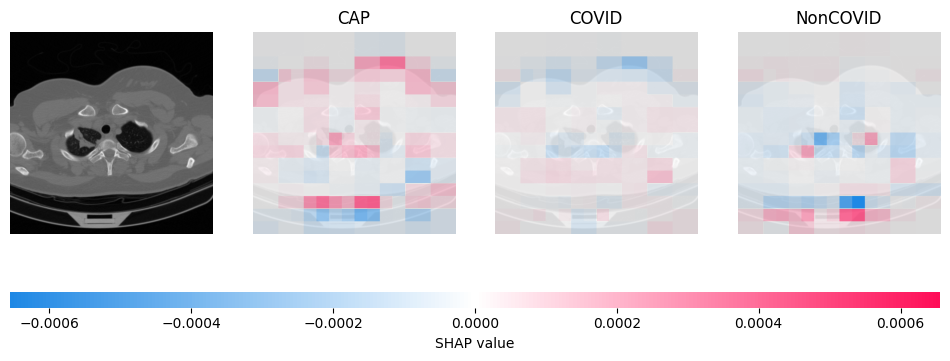

In [30]:
topk = 3
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])
print(shap_values.shape)

# original image
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
# shap heat map of each class
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

# Visualization
shap.image_plot(shap_values = shap_values.values,
                pixel_values = shap_values.data,
                labels = shap_values.output_names,
                show = False)

plt.savefig('figure/shap+_6_Rahimzadeh_normal3_patient344_SR_4_IM00022.tif', dpi = 300, bbox_inches = 'tight')

## 2. Specify a single prediction category

In [ ]:
shap_values = explainer(input_img, max_evals = n_evals, batch_size = batch_size, outputs = [0])

# original image
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
# shap heat map of each class
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

print(shap_values.data.shape)
print(shap_values.values[0].shape)

# Visualization
shap.image_plot(shap_values = shap_values.values,
                         pixel_values = shap_values.data,
                         labels = shap_values.output_names,
                         show = False)

plt.savefig('figure/shap_17_Zhao_PIIS0140673620302117_1.tif', dpi = 300, bbox_inches = 'tight')